# RHme2 piece of SCAke challenge

This is an example of using Jlsca to analyze the trace set from the simplest SCA challenge of RHme2 embedded CTF (http://rhme.riscure.com/home).

The challenge features an unprotected SW AES-128 implementation on an 8-bit AVR microcontroller. You can send plaintext blocks to the device and receive blocks of ciphertext. The device LED blinks on the start of the encryption. The goal is to recover the encryption key.

Power traces were acquired using ChipWhisperer Lite and accompanying software (https://wiki.newae.com/Main_Page). The trigger was at the start of the cipher execution by using the blinking LED. After some trivial exploration, first round S-boxes can could be identified. For the attack in this example, only the corresponding part of the execution was captured: 10000 samples, at 105 MS/s sampling rate.

The small tarball with traces is available at https://drive.google.com/open?id=0B2slHLSL3nXaWFJ0dHVPWFJqalE. Uncompress it next to this notebook.

In [1]:
# load the tools
using Jlsca.Sca
using Jlsca.Trs
using Jlsca.Align
using Jlsca.Aes
using PyCall
using PyPlot.plot,PyPlot.figure

@pyimport numpy

## Convert traces from ChipWhisperer capture to Trs format

Needed just once to create the trs file. The rest of the code uses the trs file.

In [2]:
# prefix identifying the capture, bulky as it is
# (so far have been lazy to automate based on ChipWhisperer config file)
prefix = "rhme2-pieceofscake-firstroundsboxes/2017.01.26-17.11.15_"

# read the data from chipwhisperer capture
samples = numpy.load("$(prefix)traces.npy");
input = numpy.load("$(prefix)textin.npy");
output = numpy.load("$(prefix)textout.npy");

In [18]:
# get sizes
print(size(samples))
print(size(input))
print(size(output))

(151,10000)(135,16)(135,16)

In [19]:
# set the parameters
numberOfTraces = size(input)[1] #weirdly, ChipWhisperer capture saves more traces then inputs
dataSpace = size(input)[2] + size(output)[2]
sampleType = Float32;

# create and save the trs
trs = InspectorTrace("rhme2-pieceofscake-firstroundsboxes.trs", dataSpace, sampleType, numberOfSamples)
for t in 1:numberOfTraces
  trs[t] = (vcat(input[t,:],output[t,:]), map(Float32, samples[t,:]))
end
close(trs)

Creating Inspector trs file rhme2-pieceofscake-firstroundsboxes.trs
#samples: 10000
#data:    32
type:     Float32
Wrote 135 traces in rhme2-pieceofscake-firstroundsboxes.trs


## Explore the traces

In [30]:
# load the traceset
trs = InspectorTrace("rhme2-pieceofscake-firstroundsboxes.trs");

Opened rhme2-pieceofscake-firstroundsboxes.trs, #traces 135, #samples 10000 (Float32), #data 32


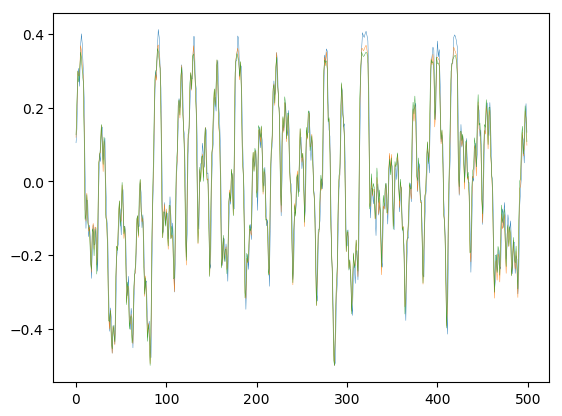

3-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x33e8db5c0>
 PyObject <matplotlib.lines.Line2D object at 0x33e8db780>
 PyObject <matplotlib.lines.Line2D object at 0x33e8db978>

In [42]:
# read and plot 3 traces with some zoom
((data,samples),eof) = readTraces(trs, 1:3);
plot(samples[1:3,1:500]', linewidth=.3); # note the transpose; and here you can play with the zoom

Well aligned, should be piece of cake indeed. Let's close the file for now.

In [43]:
close(trs)

## Run correlation power analysis
Vanilla CPA on the first round in the HW leakage model

In [45]:
trs = InspectorTrace("rhme2-pieceofscake-firstroundsboxes.trs")

params = AesSboxAttack()
params.dataOffset = 1       # plaintext starts from byte 1
params.direction = FORWARD
params.analysis = IncrementalCPA()
params.analysis.leakageFunctions = [hw]
numberOfKeyBytes = length(params.keyByteOffsets)
numberOfCandidates = getNumberOfCandidates(params)

numberOfTraces = length(trs);

setPostProcessor(trs, IncrementalCorrelation(SplitByData(numberOfKeyBytes, numberOfCandidates)))
key = sca(trs, params, 1, numberOfTraces)

Opened rhme2-pieceofscake-firstroundsboxes.trs, #traces 135, #samples 10000 (Float32), #data 32

Jlsca running in Julia version: 0.5.2, 1 processes/1 workers/1 threads per worker

AES Sbox IncrementalCPA attack parameters
leakages:   Function[Jlsca.Sca.hw]
mode:       CIPHER
key length: KL128
direction:  FORWARD
target:     Jlsca.Sca.sboxOut
data at:    1
key bytes:  [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

phase: PHASE1

Running processor Jlsca.Trs.IncrementalCorrelation on data range 0:4095, using trace set with 1 data passes, 0 sample passes


Processing traces 1:135.. 100% Time: 0:00:04


Results @ 135 traces
kb: 1
rank:   1, candidate: 0x20, peak: 0.893487 @ 815
rank:   2, candidate: 0x0f, peak: 0.449221 @ 767
rank:   3, candidate: 0xe3, peak: 0.424143 @ 9386
rank:   4, candidate: 0x03, peak: 0.413710 @ 3536
rank:   5, candidate: 0x7a, peak: 0.395729 @ 7820
kb: 2
rank:   1, candidate: 0xfb, peak: 0.894625 @ 7336
rank:   2, candidate: 0xe9, peak: 0.420591 @ 7367
rank:   3, candidate: 0x74, peak: 0.402904 @ 7089
rank:   4, candidate: 0x16, peak: 0.400719 @ 6528
rank:   5, candidate: 0xec, peak: 0.385532 @ 6803
kb: 3
rank:   1, candidate: 0x57, peak: 0.903907 @ 8326
rank:   2, candidate: 0xdf, peak: 0.452815 @ 1400
rank:   3, candidate: 0xec, peak: 0.432656 @ 1368
rank:   4, candidate: 0x3e, peak: 0.417883 @ 4614
rank:   5, candidate: 0xfa, peak: 0.396182 @ 1937
kb: 4
rank:   1, candidate: 0x41, peak: 0.925342 @ 9319
rank:   2, candidate: 0xb1, peak: 0.431720 @ 7799
rank:   3, candidate: 0x90, peak: 0.413116 @ 4943
rank:   4, candidate: 0x7f, peak: 0.409081 @ 1961
rank:  

16-element Array{UInt8,1}:
 0x20
 0xfb
 0x57
 0x41
 0xdd
 0x89
 0x49
 0x88
 0x8d
 0xf1
 0xff
 0x5b
 0xb1
 0xd7
 0x73
 0x02

Check the key using a paintext-ciphertext pair from the traceset

In [46]:
w = KeyExpansion(key, 10, 4)
Cipher(trs[1][1][1:16], w) == trs[1][1][17:32] 

true

Done.